# Basic Example


Disclaimer: Code below is largely borrowed from Amazon Braket tutorial which is no longer relevant since D-Wave systems are not available via Amazon Braket. I updated the examples to work in D-Wave leap. Below a link to the original PR by Xiaosi Xu for Amazon Braket examples repo.

https://github.com/aws/amazon-braket-examples/pull/3 

The theory behind this demo can be found in the below link.

https://www.frontiersin.org/articles/10.3389/fphy.2021.760783/full

Slide deck for this demo is linked below.

https://1drv.ms/p/s!AlYhtL0mpa8RidpJQDBRYIVcwonU4A?e=MrLDgK

In [ ]:
import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
from collections import defaultdict
import itertools
import pandas as pd
from dwave.system.samplers import DWaveSampler

In [91]:
# load dataset
data = pd.read_csv('tsp_data/five_d.txt', sep='\s+', header=None)

In [92]:
# show data set for inter-city distances
data

,0,1,2,3,4
0,0.0,3.0,4.0,2.0,7.0
1,3.0,0.0,4.0,6.0,3.0
2,4.0,4.0,0.0,5.0,8.0
3,2.0,6.0,5.0,0.0,6.0
4,7.0,3.0,8.0,6.0,0.0


In [93]:

#%%
# distance between two example cities
idx_city1 = 0
idx_city2 = 1
distance = data[idx_city1][idx_city2]
print('Distance between city {} and city {} is {}.'.format(idx_city1, idx_city2, distance))

Distance between city 0 and city 1 is 3.0.


In [94]:
# get number of cities
number_cities = data.shape[0]
print('Total number of cities:', number_cities)

Total number of cities: 5


In [95]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

In [96]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');

In [97]:
# print weights of graph
print('Weights of graph:', weights)

Weights of graph: {(0, 1): 3.0, (0, 2): 4.0, (0, 3): 2.0, (0, 4): 7.0, (1, 2): 4.0, (1, 3): 6.0, (1, 4): 3.0, (2, 3): 5.0, (2, 4): 8.0, (3, 4): 6.0}


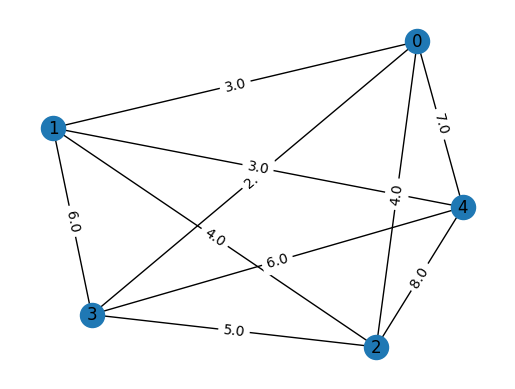

In [98]:
# show graph with weigths
plt.axis('off'); 
nx.draw_networkx(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

In [155]:
# use (classical) simulated annealing
%time route = dnx.traveling_salesperson(G, dimod.SimulatedAnnealingSampler(), start=0)
print('Route found with simulated annealing:', route)

CPU times: user 4.25 s, sys: 51.3 ms, total: 4.31 s
Wall time: 4.31 s
Route found with simulated annealing: [0, 3, 4, 1, 2]


In [151]:
# use brute force (exhaustive search)
%time exact_route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
print('Route found with exact solver (brute force):', exact_route)

CPU times: user 1min 31s, sys: 2.82 s, total: 1min 34s
Wall time: 1min 33s
Route found with exact solver (brute force): [0, 3, 4, 1, 2]


In [32]:
# get the total distance
total_dist = 0
for idx, node in enumerate(route[:-1]):
    dist = data[route[idx+1]][route[idx]]
    total_dist += dist

print('Total distance (without return):', total_dist)

Total distance (without return): 17.0


In [33]:
# add distance between start and end point to complete cycle
return_distance = data[route[0]][route[-1]]
print('Distance between start and end:', return_distance)

Distance between start and end: 2.0


In [34]:
# get distance for full cyle 
distance = total_dist + return_distance
print('Total distance (including return):', distance)

Total distance (including return): 19.0


In [154]:
%time route = dnx.traveling_salesperson(G, EmbeddingComposite(DWaveSampler()), start=0)
print('Route found with D-Wave annealer:', route)

CPU times: user 2.05 s, sys: 129 ms, total: 2.18 s
Wall time: 3.36 s
Route found with D-Wave annealer: [0, 3, 4, 2, 3]


# Inner Working and Hyper Parameter Optimization


Source Code: https://github.com/dwavesystems/dwave-networkx/blob/main/dwave_networkx/algorithms/tsp.py

In [99]:
# create list around default value for HPO 
lagrange_list= list(np.arange(int(0.8*lagrange), int(1.1*lagrange)))
print('Lagrange parameter for HPO:', lagrange_list)

Lagrange parameter for HPO: [17, 18, 19, 20, 21, 22, 23]


In [40]:
# find default Langrange parameter for enforcing constraints

# set parameters
lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)

Default Lagrange parameter: 24.0


In [100]:
lagrange = 24

In [127]:
qubo = dnx.traveling_salesperson_qubo(G, lagrange)
qubo

defaultdict(float,
            {((0, 0), (0, 0)): -44.0,
             ((0, 0), (0, 1)): 44.0,
             ((0, 0), (0, 2)): 44.0,
             ((0, 0), (0, 3)): 44.0,
             ((0, 0), (0, 4)): 44.0,
             ((0, 1), (0, 1)): -44.0,
             ((0, 1), (0, 2)): 44.0,
             ((0, 1), (0, 3)): 44.0,
             ((0, 1), (0, 4)): 44.0,
             ((0, 2), (0, 2)): -44.0,
             ((0, 2), (0, 3)): 44.0,
             ((0, 2), (0, 4)): 44.0,
             ((0, 3), (0, 3)): -44.0,
             ((0, 3), (0, 4)): 44.0,
             ((0, 4), (0, 4)): -44.0,
             ((1, 0), (1, 0)): -44.0,
             ((1, 0), (1, 1)): 44.0,
             ((1, 0), (1, 2)): 44.0,
             ((1, 0), (1, 3)): 44.0,
             ((1, 0), (1, 4)): 44.0,
             ((1, 1), (1, 1)): -44.0,
             ((1, 1), (1, 2)): 44.0,
             ((1, 1), (1, 3)): 44.0,
             ((1, 1), (1, 4)): 44.0,
             ((1, 2), (1, 2)): -44.0,
             ((1, 2), (1, 3)): 44.0,
           

In [136]:
response = sampler.sample_qubo(qubo)
sample = response.first.sample

In [137]:
response

SampleSet(rec.array([([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], -154., 1, 0.)],
          dtype=[('sample', 'i1', (25,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), Variables([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]), {'timing': {'qpu_sampling_time': 98.04, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 57.5, 'qpu_access_time': 15877.21, 'qpu_access_overhead_time': 0.0, 'qpu_programming_time': 15779.17, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 1952.0, 'post_processing_overhead_time': 1952.0}, 'problem_id': '81eeb61b-15d5-42b6-b7f0-65a689caba75'}, 'BINARY')

In [138]:
sample

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 0,
 (0, 3): 0,
 (0, 4): 0,
 (1, 0): 0,
 (1, 1): 0,
 (1, 2): 1,
 (1, 3): 1,
 (1, 4): 0,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 1,
 (2, 3): 0,
 (2, 4): 0,
 (3, 0): 1,
 (3, 1): 0,
 (3, 2): 0,
 (3, 3): 0,
 (3, 4): 0,
 (4, 0): 0,
 (4, 1): 0,
 (4, 2): 0,
 (4, 3): 0,
 (4, 4): 1}

In [139]:
route = [None]*len(G)

In [140]:
for (city, time), val in sample.items():
    if val:
        route[time] = city

In [141]:
route

[3, 0, 2, 1, 4]

In [152]:
start=0

In [153]:
if start is not None and route[0] != start:
    # rotate to put the start in front
    idx = route.index(start)
    route = route[idx:] + route[:idx]

In [124]:
route

[0, 3, 4, 2, 1]

# Larger Problem


In [159]:
# load dataset
data10 = pd.read_csv('tsp_data/data10cities.csv')
# rename columns from object to int 
dic_map = {}
for key in data10.columns:
    d = {key: int(key)}
    dic_map.update(d)
data10 = data10.rename(columns=dic_map)
# show data set for inter-city distances
data10

,0,1,2,3,4,5,6,7,8,9
0,0,29,82,46,68,52,72,42,51,55
1,29,0,55,46,42,43,43,23,23,31
2,82,55,0,68,46,55,23,43,41,29
3,46,46,68,0,82,15,72,31,62,42
4,68,42,46,82,0,74,23,52,21,46
5,52,43,55,15,74,0,61,23,55,31
6,72,43,23,72,23,61,0,42,23,31
7,42,23,43,31,52,23,42,0,33,15
8,51,23,41,62,21,55,23,33,0,29
9,55,31,29,42,46,31,31,15,29,0


{(0, 1): Text(-0.7387424363311503, 0.24885395762369436, '29'),
 (0, 2): Text(0.14490952584904543, -0.5275591997705971, '82'),
 (0, 3): Text(0.5022171652927909, 0.12064804590954539, '46'),
 (0, 4): Text(0.06624576541151152, 0.16589837669281005, '68'),
 (0, 5): Text(-0.7577712815717109, -0.3340571304059433, '52'),
 (0, 6): Text(-0.31911678479977346, 0.5695944392976113, '72'),
 (0, 7): Text(0.6785939980575041, -0.40456528884779025, '42'),
 (0, 8): Text(-0.2236059848565542, -0.7915985869979361, '51'),
 (0, 9): Text(0.21883402129335877, 0.6878819818437705, '55'),
 (1, 2): Text(-0.006129950338010143, -0.38574045730606843, '55'),
 (1, 3): Text(0.3511776891057353, 0.262466788374074, '46'),
 (1, 4): Text(-0.08479371077554404, 0.3077171191573387, '42'),
 (1, 5): Text(-0.9088107577587665, -0.19223838794141465, '43'),
 (1, 6): Text(-0.470156260986829, 0.71141318176214, '43'),
 (1, 7): Text(0.5275545218704485, -0.26274654638326156, '23'),
 (1, 8): Text(-0.37464546104360974, -0.6497798445334074, '23

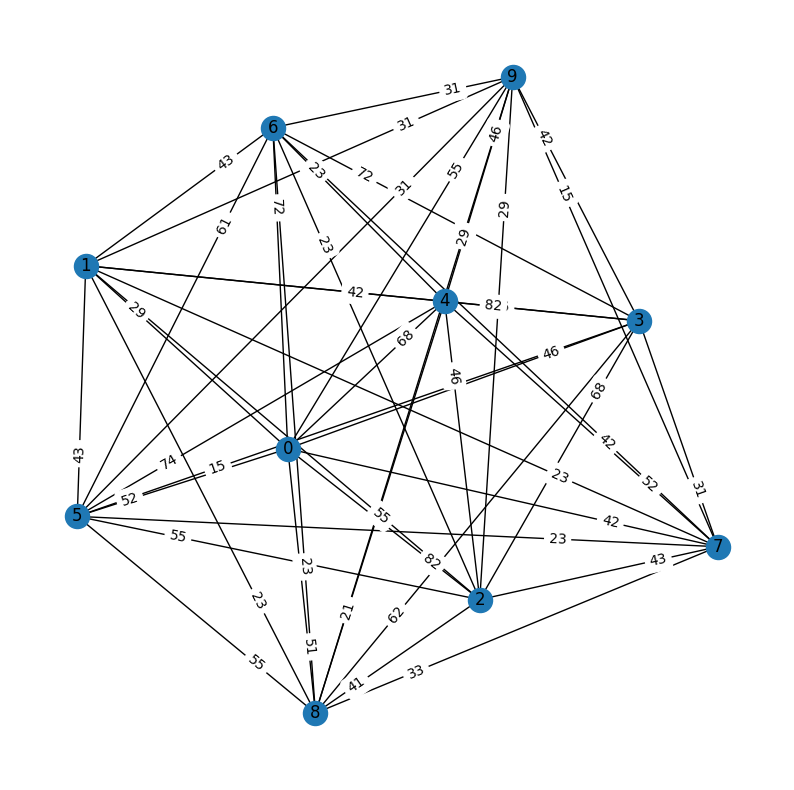

In [160]:
# G = nx.from_pandas_dataframe(data) 
G = nx.from_pandas_adjacency(data10)
# pos = nx.random_layout(G) 
pos = nx.spring_layout(G, seed=seed)

# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight')

# show graph with weigths
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, label_pos=0.25)

In [161]:
# use brute force (exhaustive search)
%time exact_route = dnx.traveling_salesperson(G, dimod.ExactSolver(), start=0)
print('Route found with exact solver (brute force):', exact_route)

ValueError: Maximum allowed dimension exceeded

In [162]:
# use (classical) simulated annealing
%time route = dnx.traveling_salesperson(G, dimod.SimulatedAnnealingSampler(), start=0)
print('Route found with simulated annealing:', route)

CPU times: user 35.8 s, sys: 447 ms, total: 36.2 s
Wall time: 36.3 s
Route found with simulated annealing: [0, 2, 9, 8, 1, 5, 3, 7, 6, 4]


In [163]:
%time route = dnx.traveling_salesperson(G, EmbeddingComposite(DWaveSampler()), start=0)
print('Route found with D-Wave annealer:', route)

CPU times: user 1min 22s, sys: 2.08 s, total: 1min 24s
Wall time: 1min 24s
Route found with D-Wave annealer: [0, 4, 0, 6, 7, None, 2, 7, 5, 9]
